<a href="https://colab.research.google.com/github/KashevarovStepan/diploma/blob/main/diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Основная программа

https://stackoverflow.com/questions/75275130/z-label-does-not-show-up-in-3d-matplotlib-scatter-plot

https://www.cfm.brown.edu/people/dobrush/am34/Mathematica/ch3/rossler.html

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from IPython.display import clear_output
from sklearn.linear_model import Ridge
from tqdm import tqdm
import multiprocessing as mp
from tqdm.contrib.concurrent import process_map
from google.colab import files
import seaborn as sns
from google.colab import drive

In [ ]:
lorenz_params = 4, 0.1, 3, 0.1, 0.25, 91393, 1, 1e-7, 10000, 1, 1e5, 0.01
rossler_params = 3, 0.4, 3, 0.1, 0.25, 91393, 1, 1e-7, 10000, 1, 1e5, 0.1

a, b, c = 0.398, 2, 4
Disc = np.sqrt(c**2 - a * b * 4)
fix1, fix2 = np.array([(c+Disc)/2, (-c-Disc)/(2*a), (c+Disc)/(2*a)]), np.array([(c-Disc)/2, (-c+Disc)/(2*a), (c-Disc)/(2*a)])

def interp_chaotic_sets(*sets):
  return np.array(list(map(lambda s: sp.interpolate.interp1d(t, s),sets)))

In [ ]:
attr_name = "dot_rossler_attr.pdf"
rec_name = "dot_long_tr_rec.pdf"
mod_name = "dot_long_tr_mod.pdf"
pdf_name = "dot_pdf.pdf"
short_name = "short_tr.pdf"

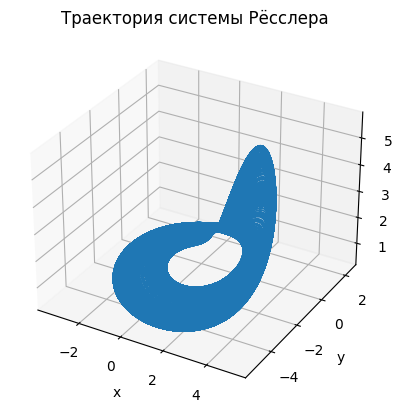

In [ ]:
D, tau, m, p, delta_grid, J, l, lamb, n, I, N_T, delta_t = rossler_params
sigma_sqr = -(((m - 1) * delta_grid) ** 2)/np.log(p)
t = np.arange(0, N_T*delta_t, delta_t)

def rossler_system(xyz, t, a, b, c):
    x, y, z = xyz
    dxdt = -y - z
    dydt = x + a*y
    dzdt = b + z*(x - c)
    return dxdt, dydt, dzdt

init_data = (1., 1., 1.4) # init_data = (1., 1., 1.4) # init_data = (fix2[0], fix2[1], fix2[2]) # init_data = (0., 0., 0.) # init_data = (3., 3., 3.)
solution = sp.integrate.odeint(rossler_system, init_data, t, args=(a, b, c))
x, y, z = solution[..., 0], solution[..., 1], solution[..., 2] # Rossler 0.88 1 0.44

wi = interp_chaotic_sets(y) # 3d for reconstruction
#wi = interp_chaotic_sets(x) # 4d for reconstruction

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Траектория системы Рёсслера')
plt.show()

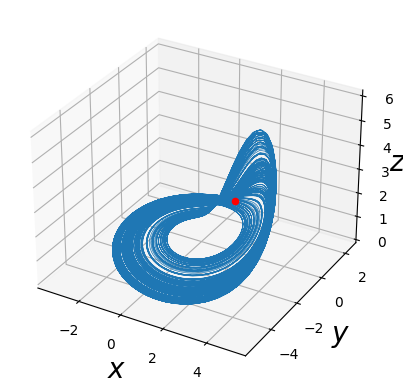

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x[:10000], y[:10000], z[:10000], lw=0.5)
ax.set_xlabel(r'$x$', fontsize=20)
ax.set_ylabel(r'$y$', fontsize=20)
ax.set_zlabel(r'$z$', fontsize=20)
ax.zaxis.labelpad=-4
#ax.set_title('Траектория системы Рёсслера')
#ax.view_init(0, 90)
ax.scatter(x[0], y[0], z[0], lw=1, color ="r")
#ax.scatter(fix1[0], fix1[1], fix1[2], lw=1, color ="g")
#ax.scatter(fix2[0], fix2[1], fix2[2], lw=1, color ="m")
#plt.savefig(attr_name, format="pdf", bbox_inches='tight')
plt.show()

# Восстановление фазового пространства

In [ ]:
# Уберем граничные моменты времени
t = t[int(D//I*tau/delta_t + 3*l*delta_t):len(t) - 5]

In [ ]:
# Функция X в координатах
def X(t):
  res = np.array([])
  for i in range(D//I):
    tmp = np.array([])
    for j in range(I):
      tmp = np.append(tmp, wi[j](t - i*tau))
    res = np.append(res, tmp)
  return res
  #return np.array(w1(t), w2(t), w1(t - tau), w2(t - tau), w1(t - 2*tau), w2(t - 2*tau))

# Estimating the time derivative
def dXdt(t):
    return 1./(60*l*delta_t)*(X(t + 3*l*delta_t) - 9*X(t + 2*l*delta_t)
    + 45*X(t + l*delta_t) - 45*X(t - l*delta_t) + 9*X(t - 2*l*delta_t)
    - X(t - 3*l*delta_t))

Xs = np.array(list(map(lambda time: X(time), tqdm(t))))
#Xs = np .array(X(t)).reshape(t.size, D)

100%|██████████| 99983/99983 [00:12<00:00, 7770.80it/s]


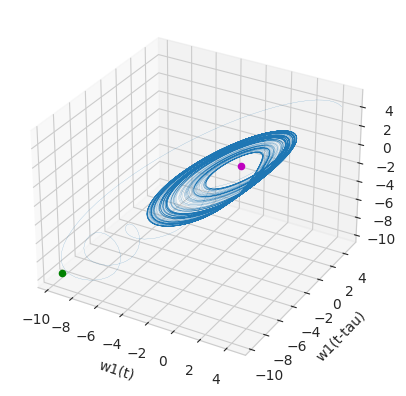

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xs[:10000, 0], Xs[:10000, 1], Xs[:10000, 2], lw=0.1)
ax.set_xlabel('w1(t)')
ax.set_ylabel('w1(t-tau)')
ax.set_zlabel('w1(t-2tau)')
ax.scatter(fix1[1], fix1[1] , fix1[1], lw=1, color ="g")
ax.scatter(fix2[1], fix2[1] , fix2[1], lw=1, color ="m")
#ax.view_init(30, -80)
#ax.set_title('Траектория восстановленной системы')
plt.show()

# Нормальный подбор точек решетки

In [ ]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [ ]:
def make_1d_grids():
  grids1d = []
  for i in range(D):
    grid1d = np.arange(Xs.min(axis=0)[i] - delta_grid*10 , Xs.max(axis=0)[i] + delta_grid*10, delta_grid)
    grids1d.append(grid1d)
  return np.array(grids1d)

grid = make_1d_grids()

def make_neighborhood_grid(data_point):
  grids1d = []
  for i in range(D):
    grid1d = np.array(list(filter(lambda point: abs(data_point[i] - point) <= (m-1)*delta_grid, grid[i])))
    grids1d.append(grid1d)
  return cartesian_product(*grids1d)

ram = 1e9 # 1 gb used for each process

def worker_rec(chunk):
    points = np.empty((0, D))
    for data_point in chunk:
      nh_grid = make_neighborhood_grid(data_point)
      for nh_point in nh_grid:
        points = np.append(points, np.reshape(nh_point, (1,D)), axis=0)
      if points.nbytes >= ram:
        points = np.unique(points, axis=0)
    return np.unique(points, axis=0)

def multi_process_rec(arr):
    num_processes = 10
    chunk_size = int(arr.shape[0] / num_processes / 10)
    chunks = [arr[i:i + chunk_size] for i in range(0, arr.shape[0], chunk_size)]
    results = process_map(worker_rec, chunks)
    return np.unique(np.concatenate(results, axis=0), axis=0)

points = multi_process_rec(Xs)

print(points.shape)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [ ]:
np.savetxt('rossler_x_points.csv', points, delimiter=',')

In [ ]:
points = np.loadtxt("/content/drive/MyDrive/diploma/rossler_points.csv", delimiter=",")
points.shape

(5699, 3)

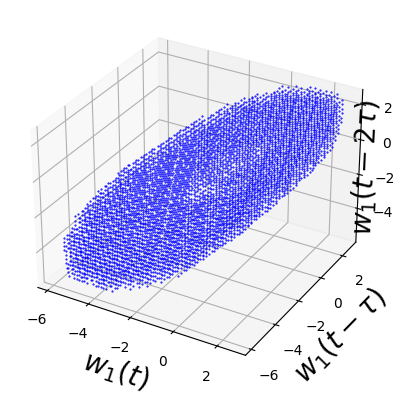

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(points[:, 0], points[:, 1], points[:, 2], 'bo', markersize=0.5)
ax.set_xlabel(r'$w_1(t)$', fontsize=20)
ax.set_ylabel(r'$w_1(t-\tau)$', fontsize=20)
ax.set_zlabel(r'$w_1(t-2\tau)$', fontsize=20, rotation=90)
ax.zaxis.labelpad=-18
#ax.set_title('Отобранные точки решетки')
plt.savefig("centers_x.pdf", format="pdf", bbox_inches='tight')
plt.show()

# Регрессия

In [ ]:
sample = np.random.choice(t, size=n, replace=False)

In [ ]:
def phi(j, point):
  return np.exp(-np.linalg.norm(point - points[j])**2/sigma_sqr)

def make_row(ti):
  row = np.array(X(ti))
  row = np.insert(row, 0, 1)
  for j in range(len(points)):
    row = np.append(row, phi(j, X(ti)))
  return row

def worker_matr(chunk):
  der, matr = np.empty((0, D)), np.empty((0, 1 + D + len(points)))
  for ti in chunk:
    der = np.append(der, np.reshape(dXdt(ti), (1, D)), axis=0)
    row = make_row(ti)
    matr = np.append(matr, np.reshape(row, (1, 1 + D + len(points))), axis=0)
  return der, matr

def multi_process_matr(arr):
    num_processes = 10
    chunk_size = int(arr.shape[0] / num_processes / 10)
    chunks = [arr[i:i + chunk_size] for i in range(0, arr.shape[0], chunk_size)]
    results = process_map(worker_matr, chunks) # list of tuples [(der, matr), (, ), ...]
    return np.array([tup[0] for tup in results]), np.array([tup[1] for tup in results])

In [ ]:
y, A = multi_process_matr(sample)

y = np.reshape(y, (-1, y.shape[2]))
A = np.reshape(A, (-1, A.shape[2]))

np.savetxt('rossler_y.csv', y, delimiter=',')
np.savetxt('rossler_A.csv', A, delimiter=',')
#files.download('rossler_y.csv')
#files.download('rossler_A.csv')

print(y.shape)
print(A.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

(10000, 3)
(10000, 6961)


In [ ]:
np.savetxt('rossler_y.csv', y, delimiter=',')
np.savetxt('rossler_A.csv', A, delimiter=',')
files.download('rossler_y.csv')
files.download('rossler_A.csv')

In [ ]:
y = np.loadtxt("rossler_y.csv", delimiter=",")
A = np.loadtxt("rossler_A.csv", delimiter=",")
print(y.shape)
print(A.shape)

In [ ]:
AT = np.transpose(A)
tmp = np.matmul(AT, A) + np.identity(A.shape[1]) * n * lamb
tmp.shape

(6961, 6961)

In [ ]:
inv = np.linalg.inv(tmp)
inv.shape

(6961, 6961)

In [ ]:
b = np.matmul(np.matmul(inv, AT), y)
b = np.transpose(b)
np.savetxt('rossler_x_b.csv', b, delimiter=',')
#files.download('rossler_x_b.csv')
b.shape

(3, 6961)

In [ ]:
b = np.transpose(b)
b.shape

(3, 5702)

In [ ]:
b = np.loadtxt("drive/MyDrive/diploma/rossler_b.csv", delimiter=",")
points = np.loadtxt("drive/MyDrive/diploma/rossler_points.csv", delimiter=",")
print(b.shape)
print(points.shape)

(3, 5703)
(5699, 3)


In [ ]:
tr_len = int(N_T*delta_t / 10)                 *1
t_init = np.arange(0, tr_len*delta_t, delta_t)
t_fin = t_init[int(D//I*tau/delta_t + 3*l*delta_t):len(t_init) - 5]
bruh = int(D//I*tau/delta_t + 3*l*delta_t)

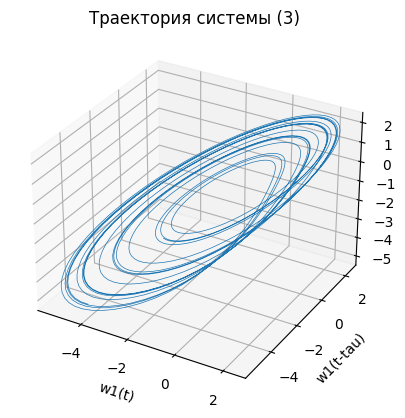

In [ ]:
# Модель ОДЕ
def model_ODE(xyz, t):
  dxdt = []
  phi_j = []
  for j in range(b.shape[1] - D - 1):
    phi_j.append(phi(j, np.array(xyz)))
  for k in range(D):
    dxidt = b[k, 0]
    for d in range(D):
      dxidt += b[k, 1 + d] * xyz[d]
    for j in range(b.shape[1] - D - 1):
      dxidt += b[k, 1 + D + j] * phi_j[j]
    dxdt.append(dxidt)
  return tuple(dxdt)

init_data = (Xs[20000, 0], Xs[20000, 1], Xs[20000, 2])                                             # 10000       20000
solution = sp.integrate.odeint(model_ODE, init_data, t_init)
x_mod, y_mod, z_mod = solution[..., 0], solution[..., 1], solution[..., 2]

Xs_mod = np.transpose(np.array([x_mod, y_mod, z_mod]))

#np.savetxt('drive/MyDrive/diploma/rossler_Xs_mod_1k_farfar_init.csv', Xs_mod, delimiter=',') # УДАЛИТЬ

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xs_mod[:, 0], Xs_mod[:, 1], Xs_mod[:, 2], lw=0.5)
ax.set_xlabel('w1(t)')
ax.set_ylabel('w1(t-tau)')
ax.set_zlabel('w1(t-2tau)')
ax.set_title('Траектория системы (3)')
plt.show()

In [ ]:
np.savetxt('drive/MyDrive/diploma/rossler_Xs_mod_1k_v2_20k_offset.csv', Xs_mod, delimiter=',')

# Результаты

In [ ]:
bruh = int(D//I*tau/delta_t + 3*l*delta_t)
offset = int(tau/delta_t)
t_init_long = np.arange(0, 1000, delta_t)
t_init_short = np.arange(0, 100, delta_t)
print(t_init_long.shape)
print(t_init_short.shape)

(10000,)
(1000,)


In [ ]:
Xs_long_part = Xs[bruh : bruh + 10000]
#Xs_short_part = Xs[bruh : bruh + 1000]                                               # 10000   20000
Xs_short_part = Xs[10000+bruh : 10000+bruh + 1000]
#Xs_short_part = Xs[20000+bruh : 20000+bruh + 1000]
print(Xs_long_part.shape)
print(Xs_short_part.shape)

(10000, 3)
(1000, 3)


In [ ]:
Xs_mod_long = np.loadtxt("drive/MyDrive/diploma/rossler_Xs_mod_10k_bias_init.csv", delimiter=",")    #drive/MyDrive/diploma/rossler_Xs_mod_1k_v1_10k_offset.csv
Xs_mod_short = np.loadtxt("drive/MyDrive/diploma/rossler_Xs_mod_1k_v1_10k_offset.csv", delimiter=",")    #
print(Xs_mod_long.shape)
#print(Xs_mod_short.shape)

(10000, 3)


In [ ]:
#Xs_mod = Xs_mod_long
Xs_mod = Xs_mod_short

Длинные траектории (аттрактор)

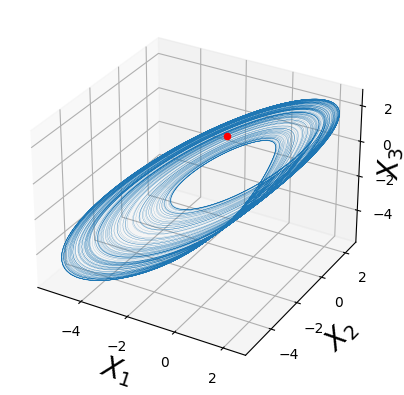

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xs_mod[bruh:, 0], Xs_mod[bruh:, 1], Xs_mod[bruh:, 2], lw=0.1)
ax.set_xlabel(r'$X_1$', fontsize=20)
ax.set_ylabel(r'$X_2$', fontsize=20)
ax.set_zlabel(r'$X_3$', fontsize=20)
ax.zaxis.labelpad=-7
#ax.set_title('Траектория системы (3)')
ax.scatter(Xs_mod[bruh, 0], Xs_mod[bruh, 1], Xs_mod[bruh, 2], lw=1, color ="r")
plt.savefig(mod_name, format="pdf", bbox_inches='tight')
plt.show()

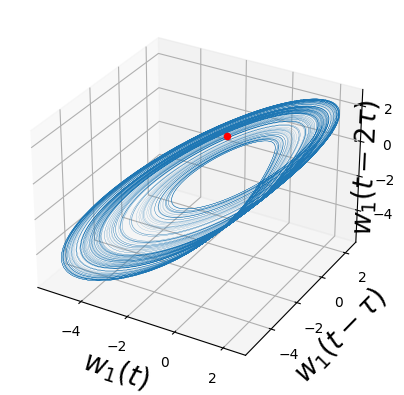

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xs_long_part[:, 0], Xs_long_part[:, 1], Xs_long_part[:, 2], lw=0.1)
ax.set_xlabel(r'$w_1(t)$', fontsize=20)
ax.set_ylabel(r'$w_1(t-\tau)$', fontsize=20)
ax.set_zlabel(r'$w_1(t-2\tau)$', fontsize=20, rotation=90)
ax.zaxis.labelpad=-18
#ax.set_title('Траектория восстановленной системы')
ax.scatter(Xs_long_part[0, 0], Xs_long_part[0, 1], Xs_long_part[0, 2], lw=1, color ="r")
plt.savefig(rec_name, format="pdf", bbox_inches='tight')
plt.show()

Короткая траектория

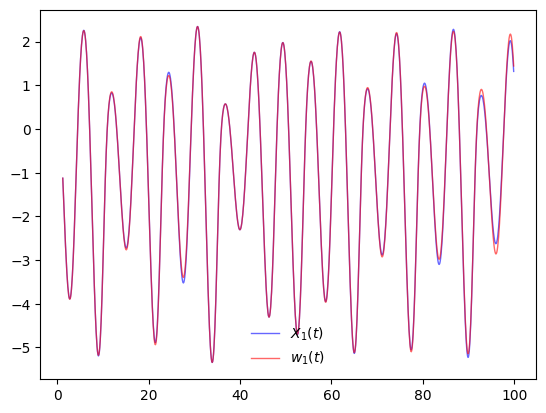

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.plot(t_init_long[bruh:1000], Xs_mod[bruh:1000, 0], 'b-', lw=1, alpha=0.6, label=r'$X_1(t)$')
ax.plot(t_init_long[bruh:1000], Xs_long_part[:1000-bruh, 0], 'r-', lw=1, alpha=0.6, label=r'$w_1(t)$')
ax.legend(loc='best', frameon=False)
plt.savefig(short_name, format="pdf", bbox_inches='tight')
plt.show()

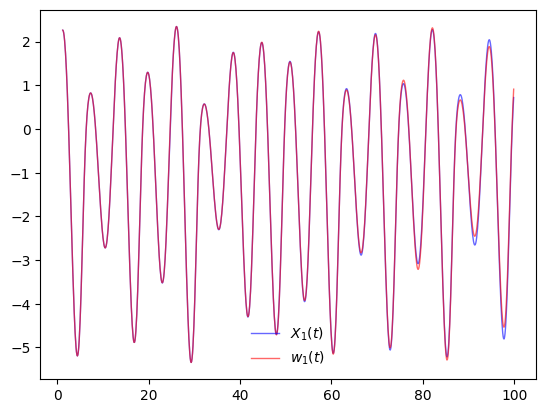

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.plot(t_init_long[bruh:1000], Xs_mod[bruh:1000, 0], 'b-', lw=1, alpha=0.6, label=r'$X_1(t)$')
ax.plot(t_init_long[bruh:1000], Xs_short_part[:-bruh, 0], 'r-', lw=1, alpha=0.6, label=r'$w_1(t)$')
ax.legend(loc='best', frameon=False)
plt.savefig("short_tr_0-100_v1.pdf", format="pdf", bbox_inches='tight')
plt.show()

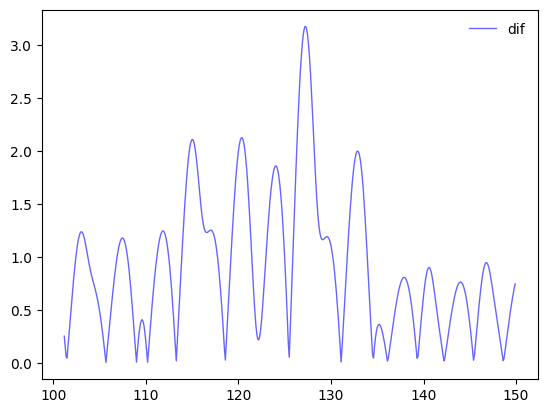

In [ ]:
fig, ax = plt.subplots(1, 1)
tmp = np.absolute(Xs_long_part[:-bruh-7000, 0] - Xs_mod[bruh:, 0])
#ax.plot(t_init_long[bruh:-7000], Xs_long_part[:-bruh-7000, 0], 'r-', lw=1, alpha=0.6, label='w1(t)')
#ax.plot(t_init_long[bruh:-7000], Xs_mod[bruh:, 0], 'b-', lw=1, alpha=0.6, label='X1(t)')
ax.plot(t_init_long[bruh+1000:-8500], tmp[1000:-1500], 'b-', lw=1, alpha=0.6, label='dif')
ax.legend(loc='best', frameon=False)
plt.show()

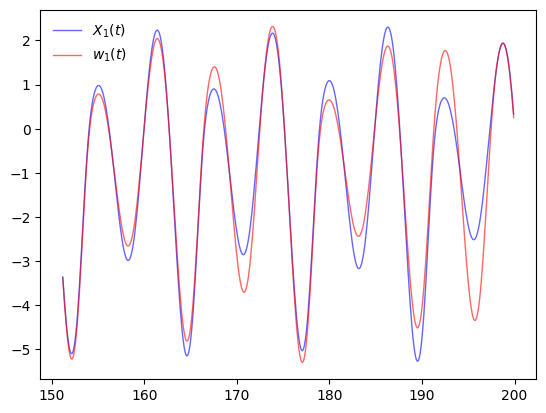

In [ ]:
fig, ax = plt.subplots(1, 1)

#ax.plot(t_init_long[bruh+1000:-8500], Xs_long_part[1000:-bruh-8500, 0], 'r-', lw=1, alpha=0.6, label=r'$w_1(t)$')
#ax.plot(t_init_long[:-9000], Xs_mod[:-9000, 0], 'b-', lw=1, alpha=0.6, label='X1(t)')
#ax.plot(t_init_long[100:-8000], Xs_mod_long[100:-8000, 0], 'b-', lw=1, alpha=0.6, label='X1(t)')

#ax.plot(t_init_short[bruh:], Xs_short_part[:-bruh, 0], 'r-', lw=1, alpha=0.6, label='w1(t)')
#ax.plot(t_init_short[:], Xs_mod_short[:, 0], 'b-', lw=1, alpha=0.6, label='X1(t)')
#ax.plot(t_init_long[bruh+1000:-8500], Xs_mod[bruh+1000:-1500, 0], 'b-', lw=1, alpha=0.6, label=r'$X_1(t)$')

ax.plot(t_init_long[bruh+1500:2000], Xs_mod[bruh+1500:2000, 0], 'b-', lw=1, alpha=0.6, label=r'$X_1(t)$')
ax.plot(t_init_long[bruh+1500:2000], Xs_long_part[1500:2000-bruh, 0], 'r-', lw=1, alpha=0.6, label=r'$w_1(t)$')
ax.legend(loc='best', frameon=False)
plt.savefig("short_tr_150-200.pdf", format="pdf", bbox_inches='tight')
plt.show()

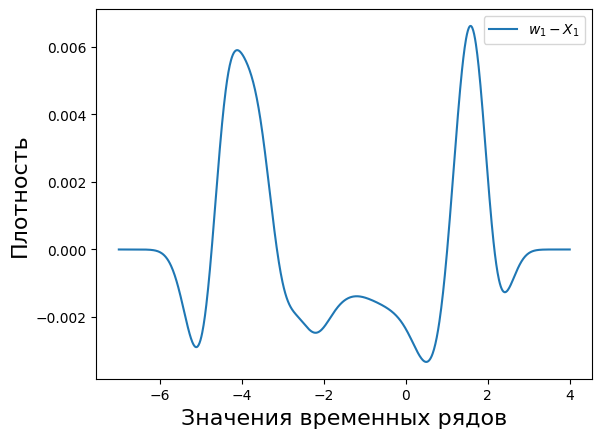

In [ ]:
kdew = sp.stats.gaussian_kde(Xs_long_part[:10000, 0])
kdex = sp.stats.gaussian_kde(Xs_mod[:, 0])
segm = np.linspace(-7 , 4, 1001)
plt.plot(segm, (kdew(segm)-kdex(segm)), label=r'$w_1-X_1$')

#sns.set_style('whitegrid')
#sns.kdeplot(df)
plt.xlabel("Значения временных рядов", fontsize=16)
plt.ylabel("Плотность", fontsize=16)
plt.legend()
plt.savefig(pdf_name, format="pdf", bbox_inches='tight')
plt.show()

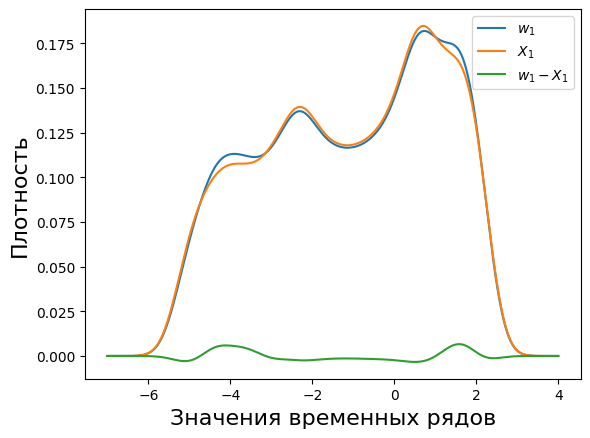

In [ ]:
kdew = sp.stats.gaussian_kde(Xs_long_part[:10000, 0])
kdex = sp.stats.gaussian_kde(Xs_mod[:, 0])
#kded = sp.stats.gaussian_kde(Xs_mod[:, 0])

segm = np.linspace(-7 , 4, 1001)

#df = pd.DataFrame(data = {r'$w_1$': kdew(segm), r'$X_1$': kdex(segm), r'$w_1-X_1$': kdew(segm)-kdex(segm)})

plt.plot(segm, kdew(segm), label=r'$w_1$')
plt.plot(segm, kdex(segm), label=r'$X_1$')
plt.plot(segm, kdew(segm)-kdex(segm), label=r'$w_1-X_1$')

#sns.set_style('whitegrid')
#sns.kdeplot(df)
plt.xlabel("Значения временных рядов", fontsize=16)
plt.ylabel("Плотность", fontsize=16)
plt.legend()
plt.savefig(pdf_name, format="pdf", bbox_inches='tight')
plt.show()

Функция распределения

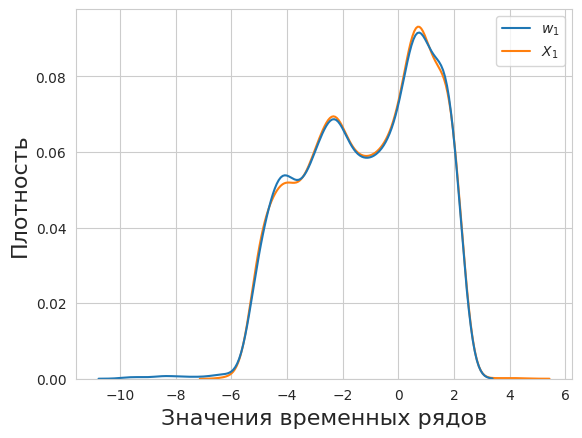

In [ ]:
df = pd.DataFrame(data = {r'$w_1$': Xs_long_part[:10000, 0], r'$X_1$': Xs_mod[:, 0]})
sns.set_style('whitegrid')
sns.kdeplot(df)
plt.xlabel("Значения временных рядов", fontsize=16)
plt.ylabel("Плотность", fontsize=16)
plt.savefig(pdf_name, format="pdf", bbox_inches='tight')

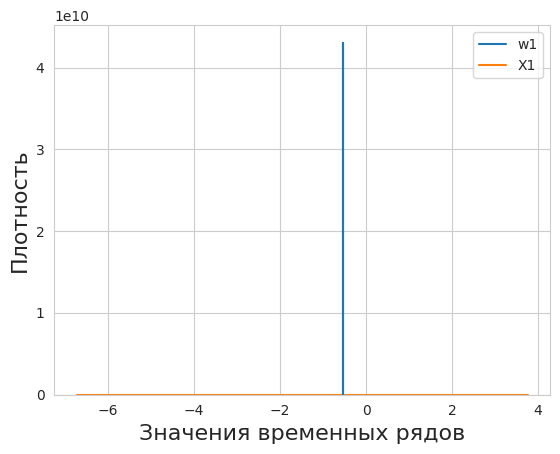

In [ ]:
df = pd.DataFrame(data = {'w1': Xs_long_part[:1000, 0], 'X1': Xs_mod[:, 0]})
sns.set_style('whitegrid')
sns.kdeplot(df)
plt.xlabel("Значения временных рядов", fontsize=16)
plt.ylabel("Плотность", fontsize=16)
plt.savefig(pdf_name, format="pdf", bbox_inches='tight')

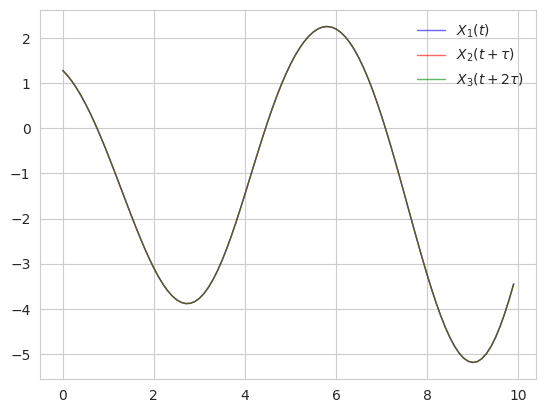

In [ ]:
fig, ax = plt.subplots(1, 1)

ax.plot(t_init_long[:100], Xs_mod[:100, 0], 'b-', lw=1, alpha=0.6, label= r'$X_1(t)$')
ax.plot(t_init_long[:100], Xs_mod[int(tau/delta_t):100+int(tau/delta_t), 1], 'r-', lw=1, alpha=0.6, label= r'$X_2(t+\tau)$')
ax.plot(t_init_long[:100], Xs_mod[2*int(tau/delta_t):100+2*int(tau/delta_t), 2], 'g-', lw=1, alpha=0.6, label= r'$X_3(t+2\tau)$')
ax.legend(loc='best', frameon=False)
#plt.savefig("short_tr_0-100.pdf", format="pdf", bbox_inches='tight')
plt.show()

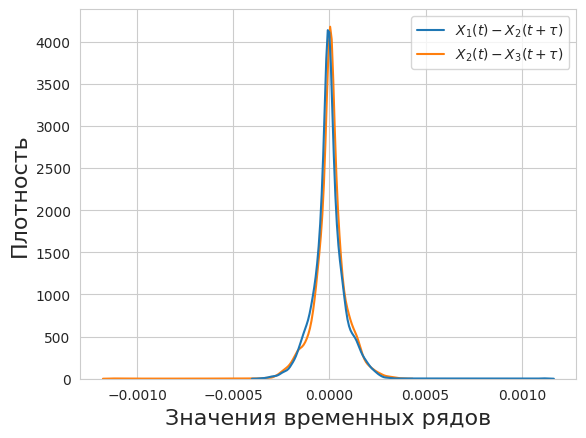

In [ ]:
df = pd.DataFrame(data = {r'$X_1(t)-X_2(t+\tau)$': Xs_mod[:-int(tau/delta_t), 0] - Xs_mod[int(tau/delta_t):, 1], r'$X_2(t)-X_3(t+\tau)$': Xs_mod[:-int(tau/delta_t), 1] - Xs_mod[int(tau/delta_t):, 2]})
sns.set_style('whitegrid')
sns.kdeplot(df)
plt.xlabel("Значения временных рядов", fontsize=16)
plt.ylabel("Плотность", fontsize=16)
plt.savefig("delay.pdf", format="pdf", bbox_inches='tight')

In [ ]:
np.savetxt('drive/MyDrive/diploma/rossler_Xs_mod_1k_bias_init.csv', Xs_mod, delimiter=',')

In [ ]:
tmp = np.loadtxt("drive/MyDrive/diploma/rossler_Xs_mod.csv", delimiter=",")
tmp.shape

(10000, 3)

## Мусор

In [ ]:
#a = np.array([1, 2, 3])
#b = np.array([4, 5])
#c = np.array([6, 7])
#pack = a, b, c
#cartesian_product(*pack)

In [ ]:
#points = np.empty((0, D))
#for data_point in tqdm(Xs):
  #nh_grid = make_neighborhood_grid(data_point)
  #for nh_point in nh_grid:
    #added = False
    #for added_point in points:
    #  if(np.array_equal(added_point, nh_point)):
    #    added = True
    #    break
    #if(not added):
    #  points = np.append(points, np.reshape(nh_point, (1,D)), axis=0)
    #if(len(points)%10000 == 0): print("Отобрано ", len(points), " точек")
    #points = np.append(points, np.reshape(nh_point, (1,D)), axis=0)
  #if points.nbytes >= ram:
    #print('amogus')
    #points = np.unique(points, axis=0)


In [ ]:
# Для регуляризации
alpha = lamb * n

#clf = Ridge(alpha=alpha)
#clf.fit(A, y)
#coefs = clf.coef_

In [ ]:
def make_y():
  der = np.empty((0, D))
  for ti in tqdm(sample):
    der = np.append(der, np.reshape(dXdt(ti), (1, D)), axis=0)
  return der

#y = np.array(list(map(lambda k: make_y(k), range(D))))
y = make_y()

100%|██████████| 10000/10000 [00:06<00:00, 1512.31it/s]


In [ ]:
def phi(j, point):
  return np.exp(-np.linalg.norm(point - points[j])**2/sigma_sqr)

def make_row(ti):
  row = np.array(X(ti))
  for j in range(len(points)):
    row = np.append(row, phi(j, X(ti)))
  return row

def make_matrix():
  matr = np.empty((0, D + len(points)))
  for ti in tqdm(sample):
    row = make_row(ti)
    matr = np.append(matr, np.reshape(row, (1, D + len(points))), axis=0)
  return matr

A = make_matrix()

 11%|█▏        | 1144/10000 [11:10<1:26:31,  1.71it/s]


KeyboardInterrupt: 

# Маленькая размерность

In [ ]:
D, tau, m, p, delta_grid, J, l, lamb, n, I, N_T, delta_t = lorenz_params
sigma_sqr = -(((m - 1) * delta_grid) ** 2)/np.log(p)
t = np.arange(0, N_T*delta_t, delta_t)

def lorenz_system(xyz, t, sigma, rho, beta):
    x, y, z = xyz
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return dxdt, dydt, dzdt

init_data = (0.3, 0.3, 0.3)
solution = sp.integrate.odeint(lorenz_system, init_data, t, args=(10, 28, 2.667))
x, y, z = solution[..., 0], solution[..., 1], solution[..., 2] # Lorenz 0.89 0.46 0.35

wi = interp_chaotic_sets(x)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Траектория системы Лоренца')
plt.show()

# Подбор точек решетки в лоб

In [ ]:
def make_grid():
  grids1d = []
  for i in range(D):
    grid1d = np.arange(Xs.min(axis=0)[i], Xs.max(axis=0)[i], delta_grid)
    grids1d.append(grid1d)
  return np.array(grids1d)

counter = 0
all_grid_points = product(*make_grid())
print(make_grid().shape)
points = []
for point in all_grid_points:
  #print(point)
  point = np.array(point)
  if(np.any(sp.spatial.distance.cdist(np.array([point]), Xs) <= (m-1)*delta_grid)):
    points.append(point)
    counter += 1
    if(counter%10 == 0): clear_output()
    print(counter)



points = np.array(points)
print(points.shape)

(6, 128)
1


KeyboardInterrupt: 

# Большая размерность

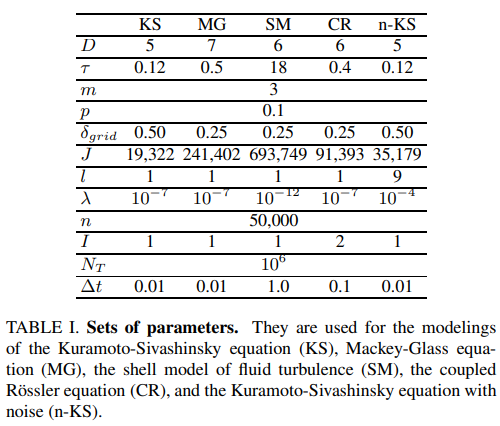

In [ ]:
#D, tau, m, p, delta, J, l, lambda, n, I, N_T, delta_t
MG_params = 7, 0.5, 3, 0.1, 0.25, 241402, 1, 1e-7, 50000, 1, 1e6, 0.01
CR_params = 6, 0.4, 3, 0.1, 0.25, 91393, 1, 1e-7, 50000, 2, 1e6, 0.1
params = CR_params
D, tau, m, p, delta_grid, J, l, lamb, n, I, N_T, delta_t = params
sigma_sqr = -(((m - 1) * delta_grid) ** 2)/np.log(p)
t = np.arange(0, N_T*delta_t, delta_t)

In [ ]:
# Coupled Rossler attractor
# (a, c, f, eps) = (0.15, 10, 0.2, 0.06)
def CR(vars, t, a, c, f, eps):
    x1, y1, z1, x2, y2, z2 = vars
    dx1dt = - y1 - z1 + eps * (x2 - x1)
    dy1dt = x1 + a * y1
    dz1dt = f + x1 * z1 - c * z1
    dx2dt = - y2 - z2 + eps * (x1 - x2)
    dy2dt = x2 + a * y2
    dz2dt = f + x2 * z2 - c * z2
    return np.array([dx1dt, dy1dt, dz1dt, dx2dt, dy2dt, dz2dt])

a, c, f, eps = 0.15, 10, 0.2, 0.06
init_data = (0., 1., 1.05, 0., 1., 1.05)

solution = sp.integrate.odeint(CR, init_data, t, args=(a, c, f, eps))
x1, y1, z1, x2, y2, z2 = solution[..., 0], solution[..., 1], solution[..., 2], solution[..., 3], solution[..., 4], solution[..., 5]

#w1, w2 = sp.interpolate.interp1d(t, x1), sp.interpolate.interp1d(t, x2)

#def interp_chaotic_sets(*sets):
#  return np.array(list(map(lambda s: sp.interpolate.interp1d(t, s),sets)))

#wi = interp_chaotic_sets(x1, x2)

# Функция x в координатах
#def x(t):
#  return np.array(x1(t), y1(t), z1(t), x2(t), y2(t), z2(t))

# Брух

In [ ]:
print(Xs[0])
print()

In [ ]:
print(t.shape)
print(X(t[0]), X(t[0]).shape)
print(Xs.shape)
print(Xs[0])
print(Xs)
Xs.min(axis=0).shape
for i in range(D):
  print((Xs.max(axis=0)[i]-Xs.min(axis=0)[i])/delta_grid)

(999992,)
[-0.85207041 -0.85207041 -0.50372765 -0.50372765  0.          0.        ] (6,)
(999992, 6)
[-0.85207041 -0.85207041 -0.50372765 -0.50372765  0.          0.        ]
[[ -0.85207041  -0.85207041  -0.50372765  -0.50372765   0.
    0.        ]
 [ -0.92243442  -0.92243442  -0.59940605  -0.59940605  -0.16739719
   -0.16739719]
 [ -0.98452555  -0.98452555  -0.6897532   -0.6897532   -0.29322114
   -0.29322114]
 ...
 [-13.01991083 -13.01991083  -9.76348695  -9.76348695  -5.1993881
   -5.1993881 ]
 [-13.55289039 -13.55289039 -10.72777071 -10.72777071  -6.42228877
   -6.42228877]
 [-13.95745555 -13.95745555 -11.59856764 -11.59856764  -7.59888586
   -7.59888586]]
127.60289311915986
127.60289311915986
127.60289311907627
127.60289311907627
127.60289311907627
127.60289311907627


# Проверка

In [ ]:
list(map(lambda x: x**2, range(3)))

[0, 1, 4]

In [ ]:
 np.unique(np.concatenate([[[1, 2], [3, 4]], [[5, 6], [7, 8]]], axis=0), axis=0)

array([[1, 2],
       [3, 4],
       [5, 6],
       [7, 8]])

In [ ]:
a = np.array([[1,2], [3,4]])
np.savetxt('test.csv', a, delimiter=',')
a

array([[1, 2],
       [3, 4]])

In [ ]:
a1, a2 = np.array([1,2,3]), np.array([3,4,5])
a = np.array([])
newrow = [1, 2, 3]
a = np.vstack([a, newrow])
print(a.shape)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 3

In [ ]:
a1, a2 = np.array([1,2]), np.array([3,4])
t = np.array([0, 1])

def interp_chaotic_sets(*sets):
  return np.array(list(map(lambda s: sp.interpolate.interp1d(t, s),sets)))

a = interp_chaotic_sets(a1, a2)
print(a[0])
print(a.shape)
print(a.size)

(2,)
2


In [ ]:
a = np.array([1])
b = np.array([2, 3])
a = np.append(a, b)
print(a.shape)
a

(3,)


array([1, 2, 3])

In [ ]:
# Функция X в координатах
def X(t):
  res = np.array([])
  for i in range(D//I):
    tmp = np.array([])
    for j in range(I):
      tmp = np.append(tmp, wi[j](t - i*tau))
    res = np.append(res, tmp)
  return res

def X_prev(t):
  return np.array([wi[0](t), wi[1](t), wi[0](t - tau), wi[1](t - tau), wi[0](t - 2*tau), wi[1](t - 2*tau)])

print(X(1))
print(X_prev(1))
print(math.dist(X(1), X_prev(1)))
print(math.dist(X(10), X_prev(10)))
print(math.dist(X(100), X_prev(100)))

[-0.98452555 -0.98452555 -0.6897532  -0.6897532  -0.29322114 -0.29322114]
[-0.98452555 -0.98452555 -0.6897532  -0.6897532  -0.29322114 -0.29322114]
0.0
0.0
0.0


In [ ]:
a = np.array([0, 1, 2, 3])
def func(k):
  return np.array([k+1, 2*k+1])
b = np.array(func(a))
print(a.shape)
print(b.shape)
print(b)


(4,)
(2, 4)
[[1 2 3 4]
 [1 3 5 7]]


In [ ]:
print('aaa')
clear_output()
print('bbb')

bbb


In [ ]:
a = np.array([[1,2],[3,4],[5,6]])
print(a.shape)
list(product(*a))

(3, 2)


[(1, 3, 5),
 (1, 3, 6),
 (1, 4, 5),
 (1, 4, 6),
 (2, 3, 5),
 (2, 3, 6),
 (2, 4, 5),
 (2, 4, 6)]

In [ ]:
a = np.array([[1,2],[3,4]])
a[0]

array([1, 2])

In [ ]:
a = np.empty((0,2))
b = np.array([1, 2])
a = np.append(a, np.reshape(b, (1,2)), axis = 0)
print(a.shape)
a = np.append(a, np.array([[3, 4]]), axis = 0)
print(a.shape)
a

(1, 2)
(2, 2)


array([[1., 2.],
       [3., 4.]])

In [ ]:
a = 0
for time in tqdm(t):
  a += 1

100%|██████████| 999992/999992 [00:00<00:00, 1061434.86it/s]


In [ ]:
a = [[1,2,3],[4,5]]
tmp = str(len(a)) + ': '
for sub in a:
  tmp += str(len(sub)) + ', '
tmp

'2: 3, 2, '

In [ ]:
a = np.array([[1,2,3],[4,5,6]])
len(a)

2

# Я хочу плакать 😢

1) Надо 37гб оперативы для матрицы A нужных размеров(50k x 100k)

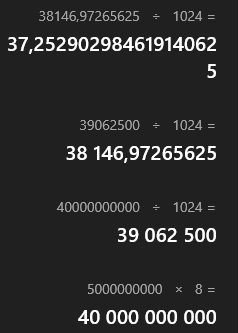

2) Для отбора точек решетки в лоб надо 2 тысячелетия

3) Для второго способа тоже надо много(до сдачи диплома осталось менее 43к часов):

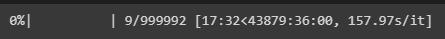

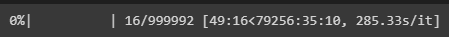

**Понизить размерность?**